In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
import itertools as it

from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, tanimoto_kernel
from scipy.spatial._distance_wrap import cdist_cityblock_double_wrap
from ssvm.feature_utils import CountingFpsBinarizer

In this notebook we investigate whether the ECFP and FCFP fingerprints calculated for MassBank data, can distinguish between different stereo isomers of molecular candidates.

In [6]:
def load_data(acc, fp_def, conn):
    return pd.read_sql(
        "select accession, \
           scored_spectra_meta_with_molecule_information.cid as gt_cid, \
           m.cid as cand_cid, \
           m.inchikey1, \
           m.inchikey2, \
           m.smiles_iso, \
           bits, \
           \"values\" \
        from ( \
            select accession, inchikey1, cid \
                from scored_spectra_meta \
                inner join molecules m on m.cid = scored_spectra_meta.molecule \
                where accession in %s \
        ) scored_spectra_meta_with_molecule_information \
        inner join molecules m on m.inchikey1 = scored_spectra_meta_with_molecule_information.inchikey1 \
        inner join fingerprints_data fd on fd.molecule = m.cid \
        where fd.name is '%s' \
        order by accession" % (acc, fp_def), 
        conn
    )

def fp_str2mat(bits_values, fp_def, conn):
    d = conn.execute("SELECT length FROM fingerprints_meta WHERE name IS ?", (fp_def, )).fetchone()[0]
    
    X = np.zeros((len(bits_values), d))
    
    for i, (bits, values) in enumerate(bits_values):
        X[i, list(map(int, bits.split(",")))] = list(map(int, values.split(",")))
        
        #for j_cnt in fp_str.split(","):
        #    j, cnt = j_cnt.split(":")
        #    X[i, int(j)] = float(cnt)
        
    return X

def plot_kernel_matrices(df, fp_def, conn, cell_size=8, max_isomers=10, n_rows=5, n_cols=3):
    # Compute kernel matrix
    KX = generalized_tanimoto_kernel(
        fp_str2mat(list(zip(df["bits"].to_list(), df["values"].to_list())), fp_def, conn)
    )
    
    fig, axrr = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * cell_size, n_rows * cell_size))
    
    pidx = 0

    for a in df["accession"].unique(): 
        sel = np.where(df["accession"] == a)[0]

        # Skip visualization for accession with only one stereo configuration
        if len(sel) < 2:
            continue

        # Search for the ground truth structure and mark its row-label
        row_labels = df["inchikey2"].iloc[sel].to_list()
        i_gt = -1
        for i in range(len(row_labels)):
            if df["gt_cid"].iloc[sel].iloc[i] == df["cand_cid"].iloc[sel].iloc[i]:
                row_labels[i] = "* " + row_labels[i]
                i_gt = i

        assert i_gt >= 0

        # Subset maximum 15 stereo-isomers
        sel_sub = sel[:max_isomers]
        row_labels_sub = row_labels[:max_isomers]
        if i_gt >= max_isomers:
            sel_sub[0] = i_gt
            row_labels_sub[0] = row_labels[i_gt]

        r, c = np.unravel_index(pidx, axrr.shape)
        sns.heatmap(
            data=pd.DataFrame(KX[np.ix_(sel_sub, sel_sub)], index=row_labels_sub), annot=True, square=True, 
            xticklabels=False, cbar=False, ax=axrr[r, c]
        )
        axrr[r, c].set_title(a)
        pidx += 1
    
    return fig, axrr
    
def generalized_tanimoto_kernel_FAST(X, Y):
    """
    Generalized tanimoto kernel function

    :param X:
    :param Y:
    :return:
    """
    XL1 = np.core.add.reduce(np.abs(X), axis=1)[:, np.newaxis]
    YL1 = np.core.add.reduce(np.abs(Y), axis=1)[:, np.newaxis]
    XmYL1 = np.empty((X.shape[0], Y.shape[0]), dtype=np.double)
    cdist_cityblock_double_wrap(np.array(X, order="c", dtype=np.double),
                                np.array(Y, order="c", dtype=np.double), XmYL1)

    XL1pYL1t = XL1 + YL1.T
    K_gtan = (XL1pYL1t - XmYL1) / (XL1pYL1t + XmYL1)

    return K_gtan

### Load Random Accessions

In [7]:
conn = sqlite3.connect("../db/massbank__with_metfrag.sqlite")

# acc, _ = zip(*conn.execute("SELECT accession, dataset FROM scored_spectra_meta ORDER BY RANDOM() LIMIT 20").fetchall())
# print(acc)
acc = ('LQB4003408', 'EA55854233', 'PR74621056', 'EA82471592', 'AU10646364', 'EA03890566', 'PR59940736', 
       'AC81323334', 'AC84083646', 'EA09375566', 'SM64711585', 'LU60842845', 'SM76109866', 'BS17901474', 
       'EQ91507857', 'AU19846649', 'LU80674228', 'PR13683311', 'AC33207679', 'EA22341362')

### ECFP Fingerprints (all)

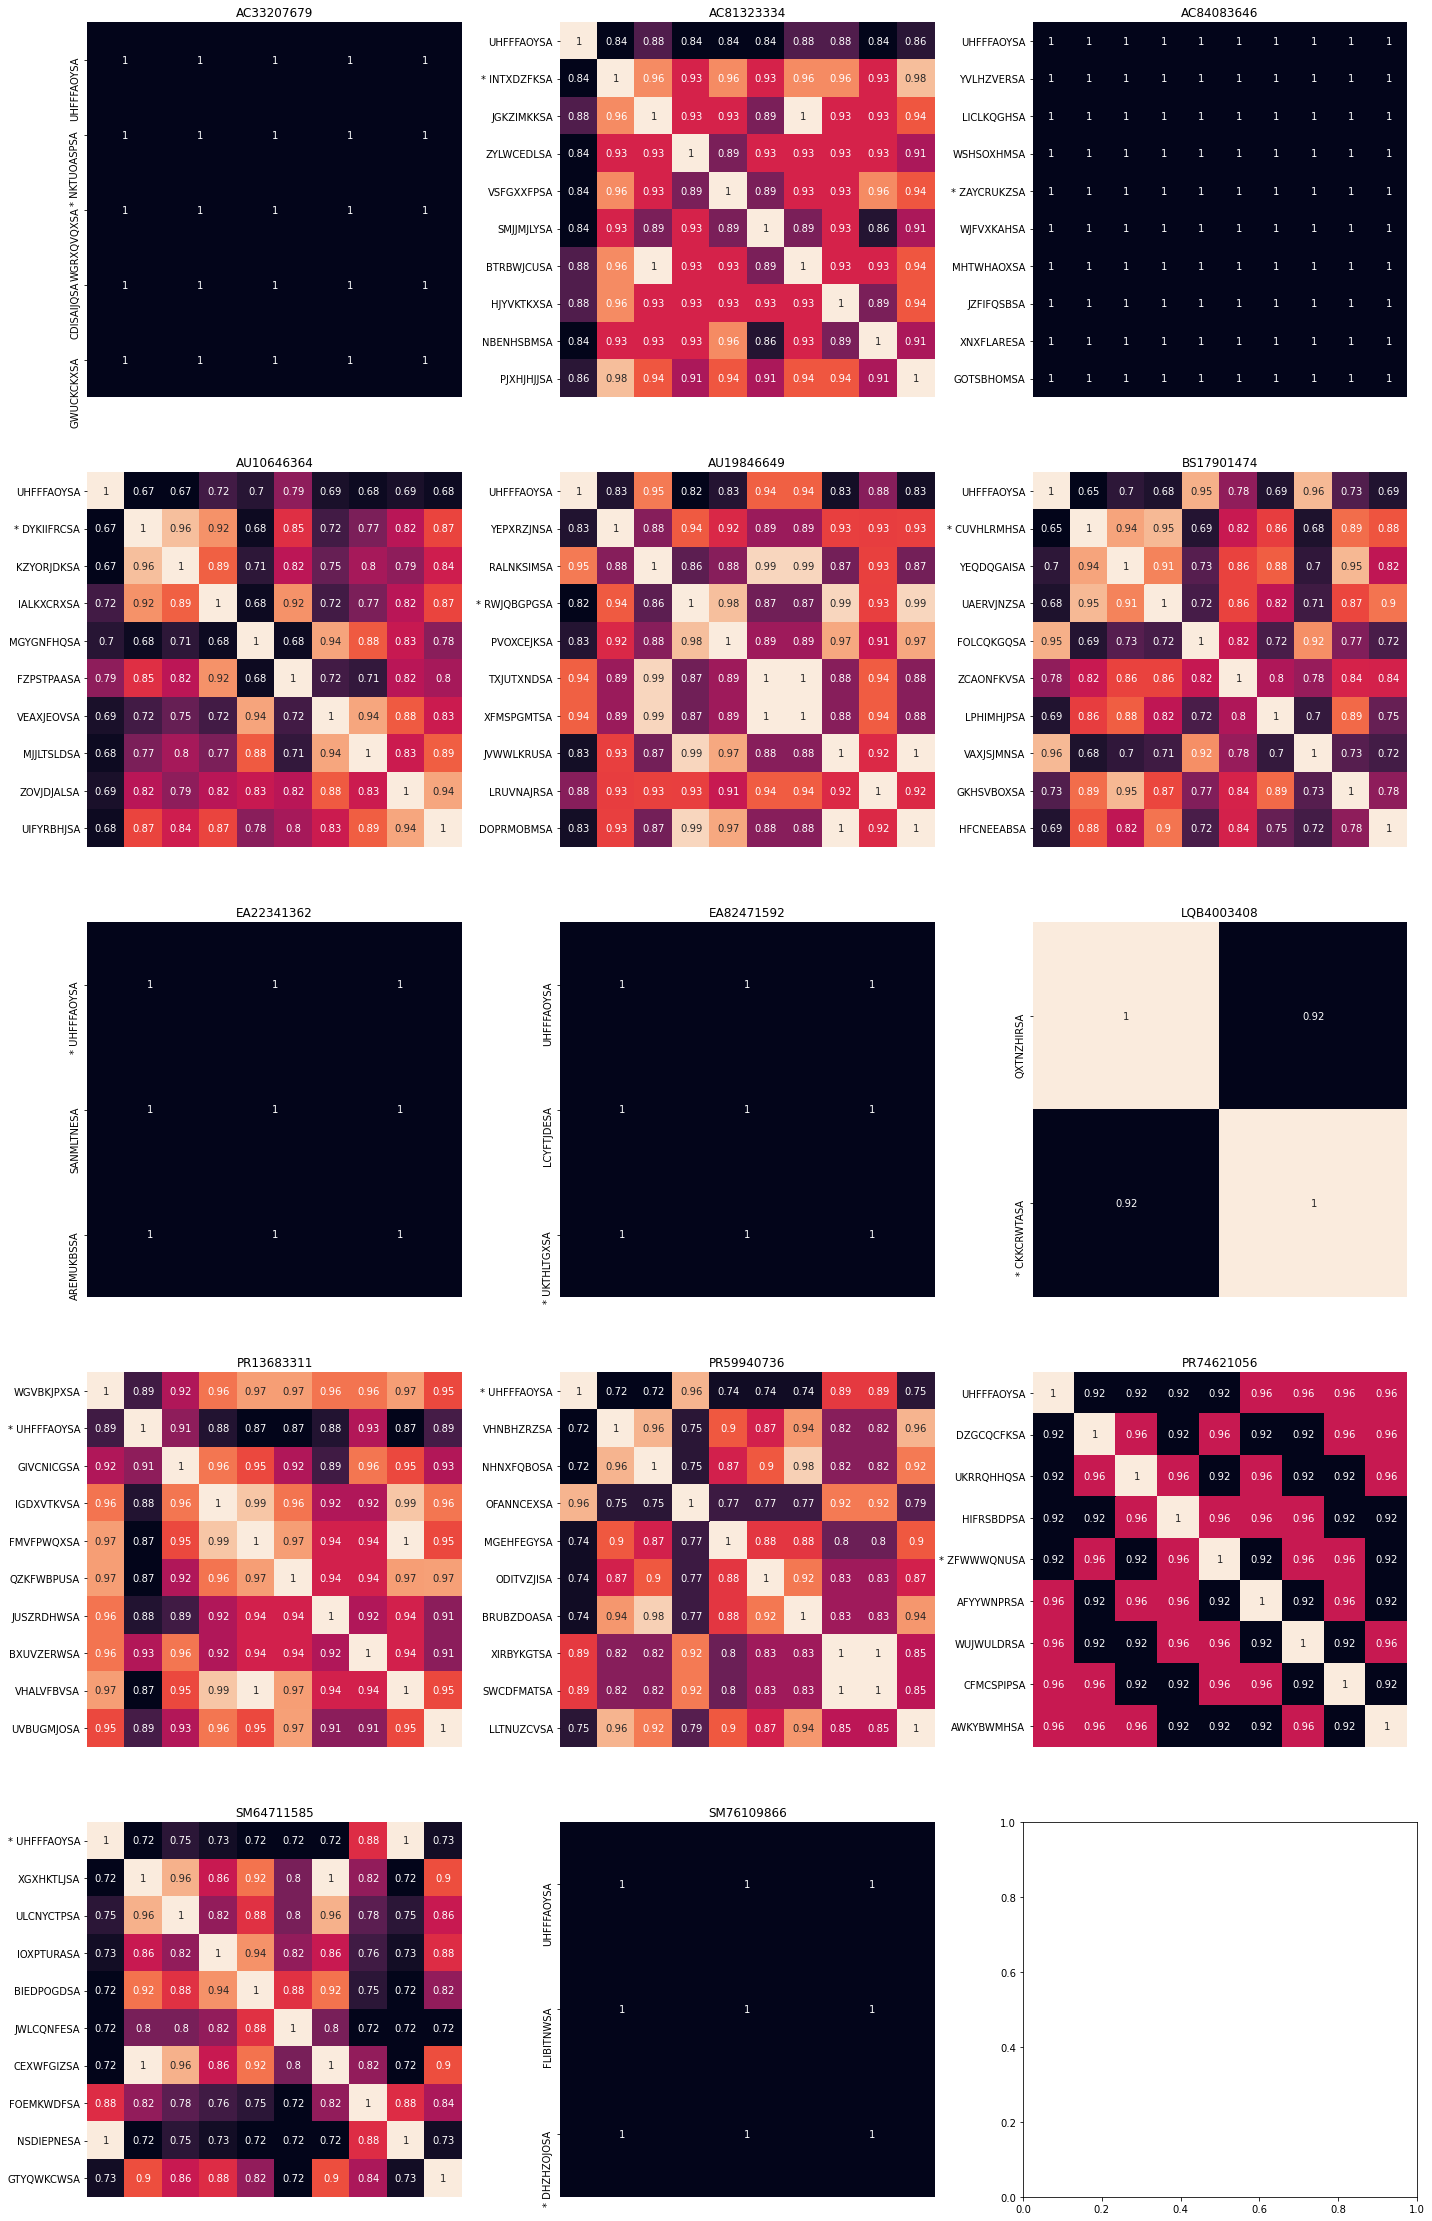

In [105]:
fp_def = "ECFP__count__all"
_ = plot_kernel_matrices(load_data(acc, fp_def, conn), fp_def, conn)

### FCFP Fingerprints (all)

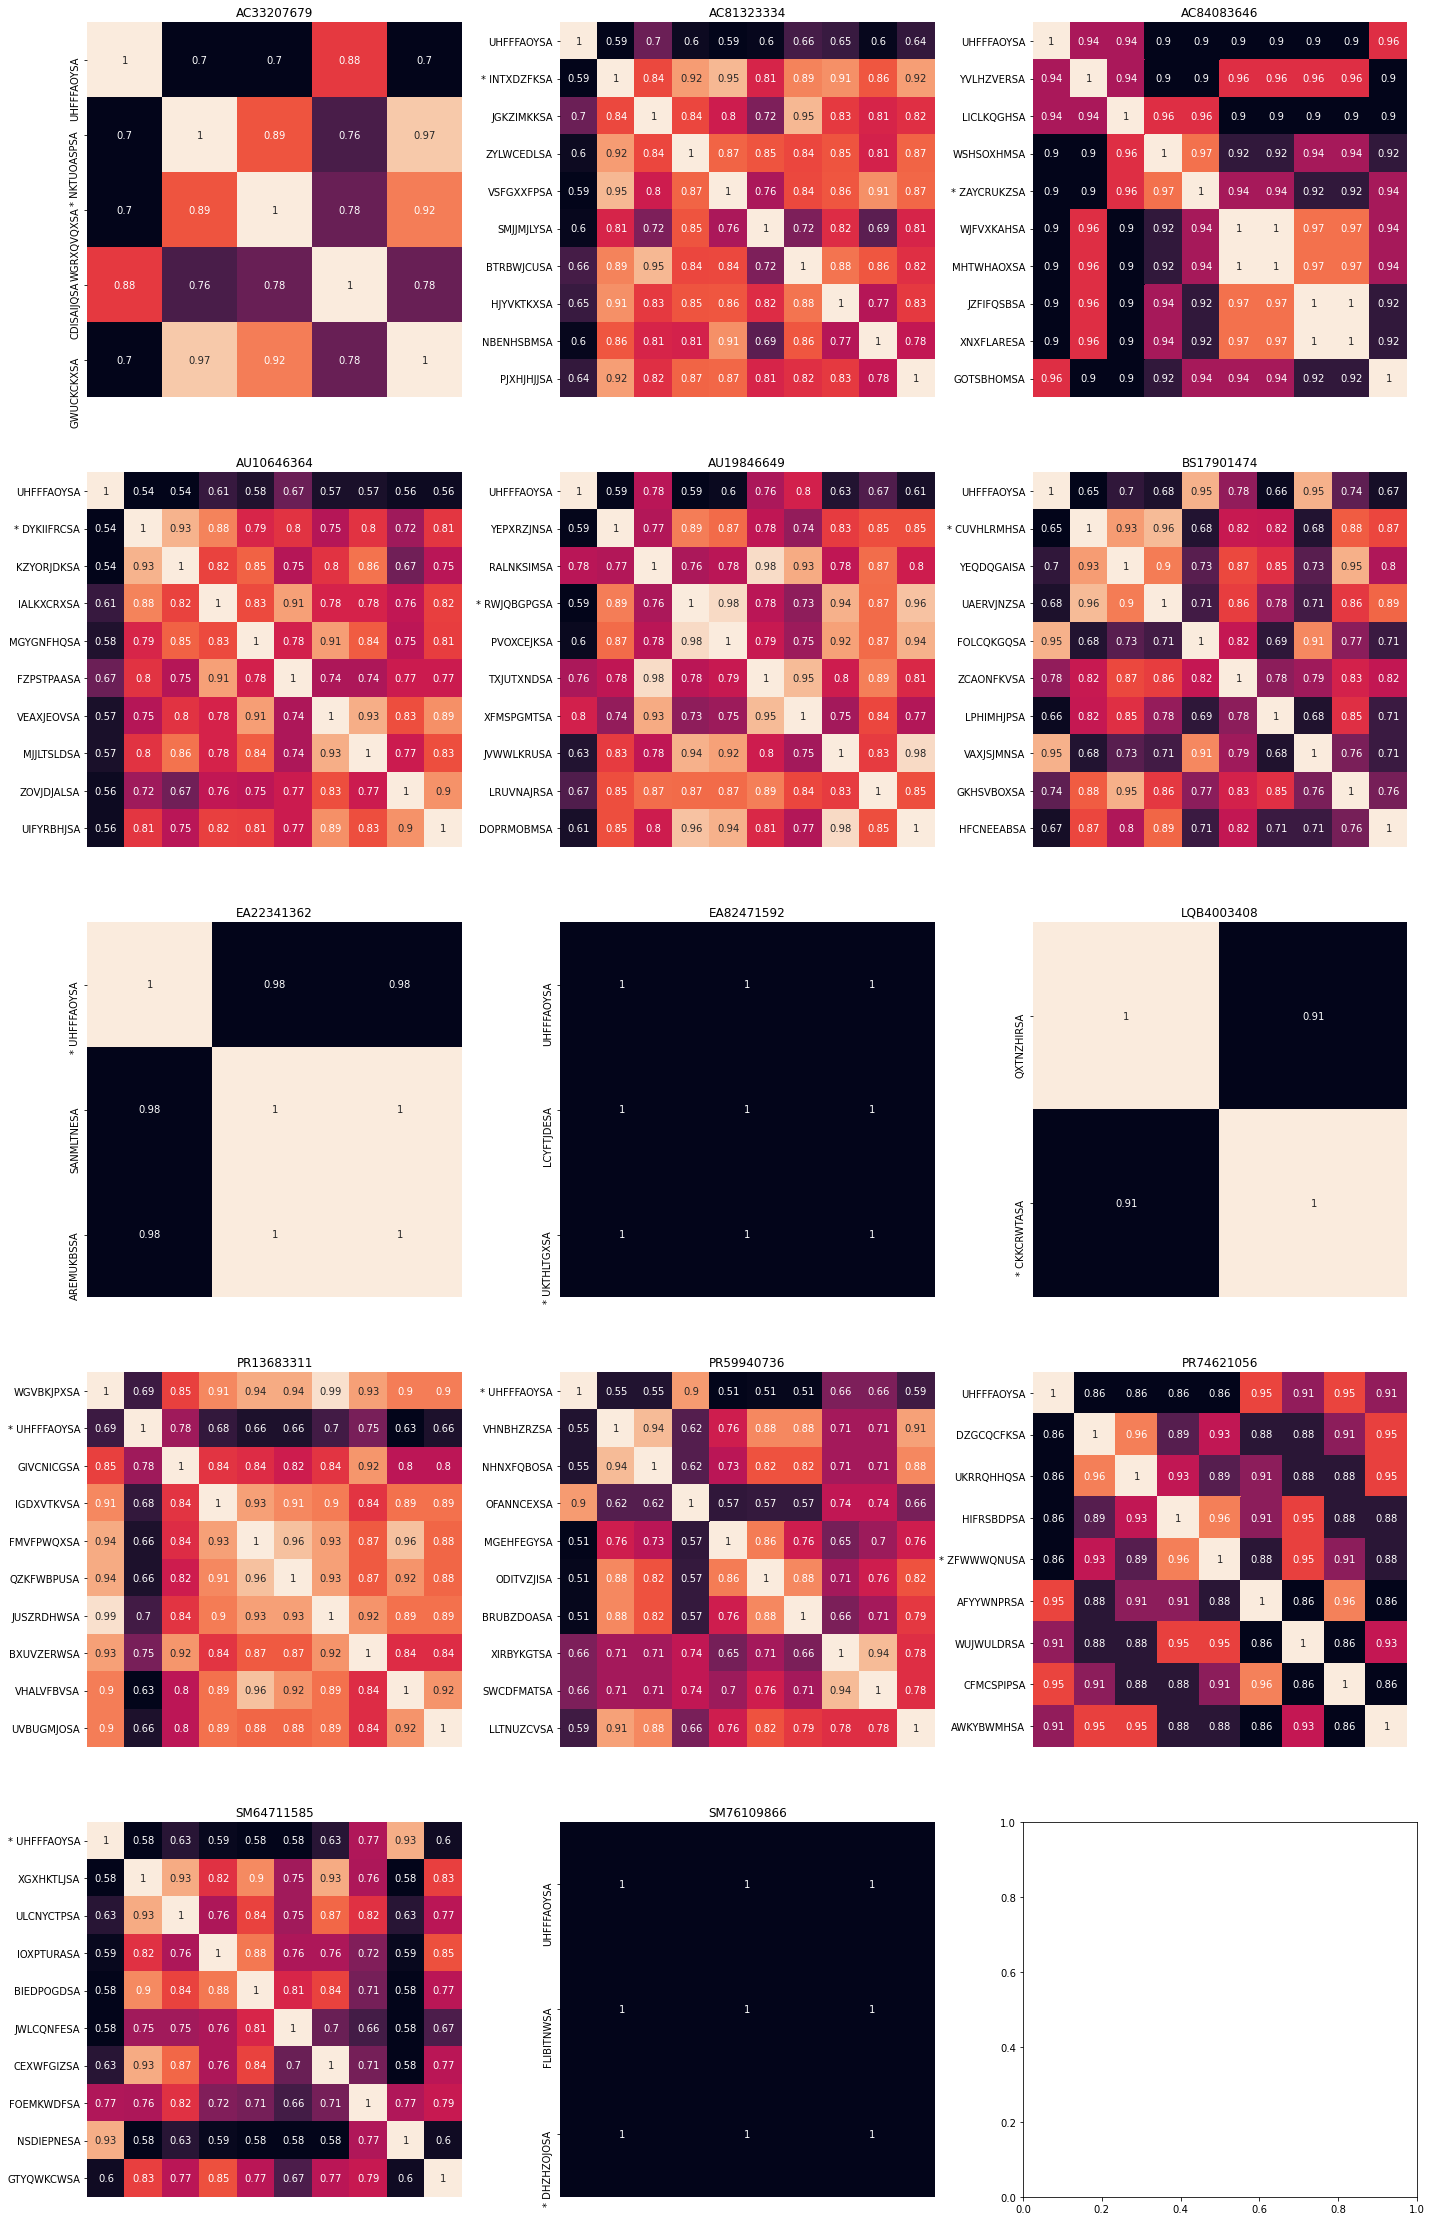

In [106]:
fp_def = "FCFP__count__all"
_ = plot_kernel_matrices(load_data(acc, fp_def, conn), fp_def, conn)

### How well do the similarities calculated from different fingerprints correlate?

In [21]:
fp_defs = ["FCFP__count__all", "ECFP__count__all", "estate_idc", "estate_cnt"]

KX = {}
X = {}
acc_kernels, = zip(*conn.execute("SELECT accession FROM scored_spectra_meta ORDER BY RANDOM() LIMIT 2000").fetchall())
for fp_def in fp_defs[:2]:
    X[fp_def] = conn.execute(
        "SELECT bits, vals FROM scored_spectra_meta \
            INNER JOIN fingerprints_data fd ON fd.molecule = scored_spectra_meta.molecule \
            WHERE fd.name IS '%s' AND accession IN %s" % (fp_def, acc_kernels)
    ).fetchall()
    X[fp_def] = fp_str2mat(X[fp_def], fp_def, conn)
    KX[fp_def] = generalized_tanimoto_kernel(X[fp_def], n_jobs=4)

KeyError: 'estate_idc'

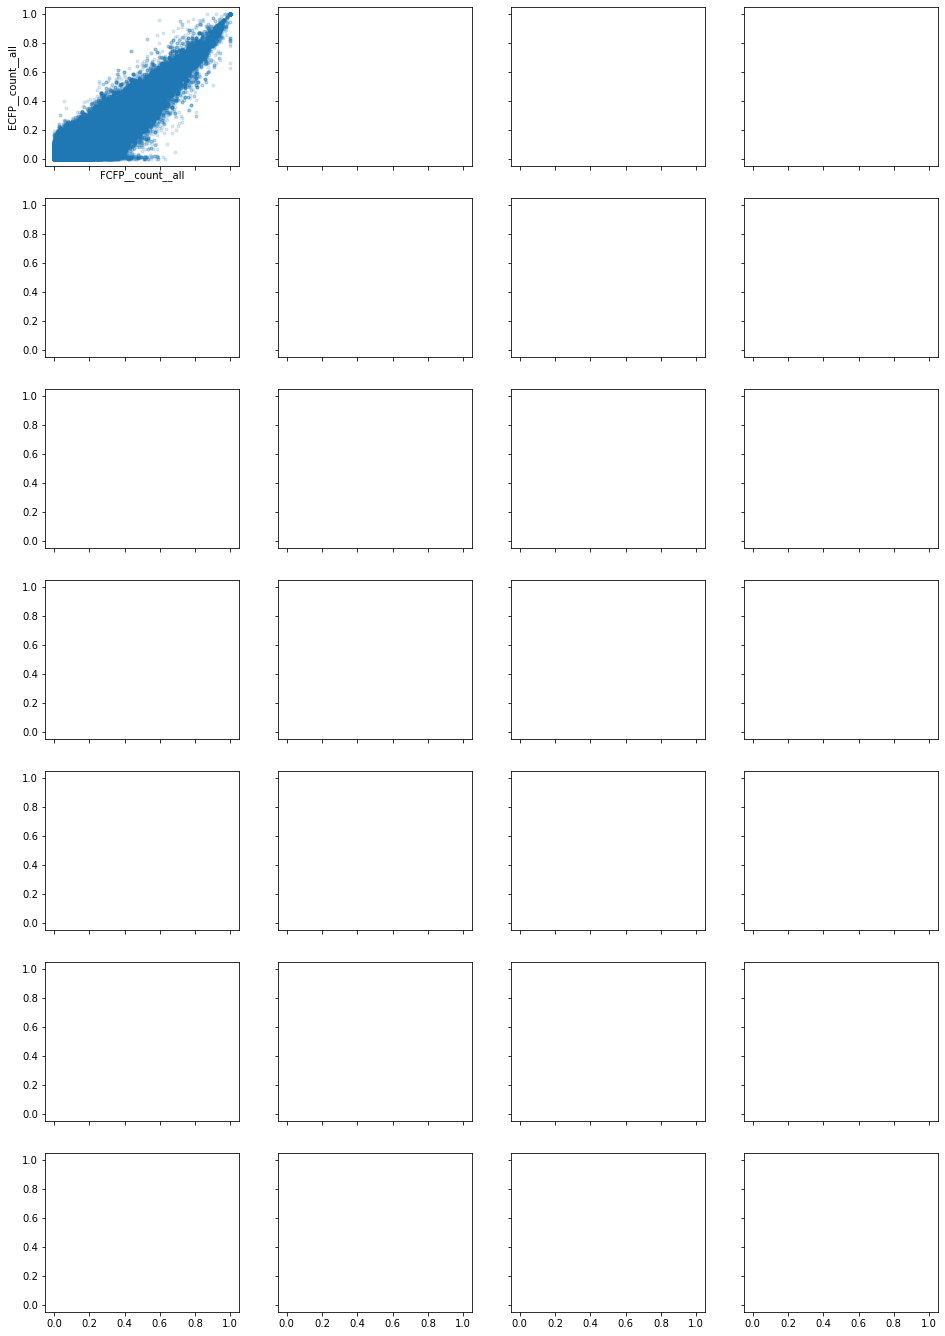

In [22]:
fig, axrr = plt.subplots(7, 4, figsize=(16, 24), sharex=True, sharey=True)
for i, (fd1, fd2) in enumerate(it.combinations(fp_defs, 2)):    
    r, c = np.unravel_index(i, axrr.shape)
    axrr[r, c].scatter(
        KX[fd1][np.triu_indices(len(acc_kernels), k=1)],
        KX[fd2][np.triu_indices(len(acc_kernels), k=1)],
        marker='.', alpha=0.15
    )
    axrr[r, c].set_xlabel(fd1)
    axrr[r, c].set_ylabel(fd2)

In [23]:
for fp_def in fp_defs[:2]:
    max_counts = conn.execute("SELECT max_values FROM fingerprints_meta WHERE name IS ?", (fp_def, )).fetchone()[0]
    bin_centers = [np.arange(int(mc)) + 1 for mc in max_counts.split(",")]
    
    X_trans = CountingFpsBinarizer(bin_centers=bin_centers, compress=False).fit_transform(X[fp_def])
    
    print("%s: orig_dim=%d, trans_dim=%d" % (fp_def, X[fp_def].shape[1], X_trans.shape[1]))
    
    assert np.array_equal(KX[fp_def], tanimoto_kernel(X_trans, shallow_input_check=True))

FCFP__count__all: orig_dim=1610, trans_dim=6925
ECFP__count__all: orig_dim=2361, trans_dim=9499
